In [3]:
from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
import mplfinance as finance
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
import math

In [4]:
ticker = "gold"
start_date = datetime.date(2010, 1, 1)
#end_date = datetime.date.today()
end_date = datetime.date.today() - datetime.timedelta(days=15)


data = pd.read_csv('data2.csv', header=0)
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,close,low,high,volume,Adj Close
0,2007-03-19,1000.0,947.80,940.00,1105.0,63128585.34,1000.00
1,2007-03-20,957.8,942.39,940.05,957.8,24674935.10,947.80
2,2007-03-21,948.0,945.67,944.10,948.5,12035364.29,942.39
3,2007-03-22,950.0,950.15,946.00,951.9,9859948.45,945.67
4,2007-03-23,950.0,947.18,945.00,951.0,13198594.08,950.15


In [5]:
df.reset_index(inplace=True,drop=False)
df.drop(['index','open','low','high','Adj Close'],axis=1,inplace=True)
df.head()

,date,close,volume
0,2007-03-19,947.80,63128585.34
1,2007-03-20,942.39,24674935.10
2,2007-03-21,945.67,12035364.29
3,2007-03-22,950.15,9859948.45
4,2007-03-23,947.18,13198594.08


In [6]:
df['date'] = df['date'].apply(datetime.datetime.toordinal)
df.head()

,date,close,volume
0,732754,947.80,63128585.34
1,732755,942.39,24674935.10
2,732756,945.67,12035364.29
3,732757,950.15,9859948.45
4,732758,947.18,13198594.08


In [7]:
df = list(df.itertuples(index=False, name=None))
dates = np.array([q[0] for q in df], dtype=int)
close_v = np.array([q[1] for q in df])
volume = np.array([q[2] for q in df])[1:]

In [8]:
diff = np.diff(close_v)
diff[:10]

array([-5.41,  3.28,  4.48, -2.97, -6.47,  2.94,  3.25,  0.15, -2.23,
       -4.44])

In [9]:
dates = dates[1:]
dates[:10]

array([732755, 732756, 732757, 732758, 732761, 732763, 732764, 732765,
       732711, 732739])

In [10]:
close_v = close_v[1:]
close_v.shape

(2338,)

In [11]:
X = np.column_stack([diff, volume])

In [12]:
X[:10]

array([[-5.41000000e+00,  2.46749351e+07],
       [ 3.28000000e+00,  1.20353643e+07],
       [ 4.48000000e+00,  9.85994845e+06],
       [-2.97000000e+00,  1.31985941e+07],
       [-6.47000000e+00,  6.03949520e+06],
       [ 2.94000000e+00,  4.43333641e+06],
       [ 3.25000000e+00,  3.48799696e+06],
       [ 1.50000000e-01,  2.61966938e+06],
       [-2.23000000e+00,  1.83976186e+06],
       [-4.44000000e+00,  1.70835469e+07]])

In [13]:
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state

hidden_states = model.predict(X)
print("done")

print("Transition matrix - probability of going to any particular state")
print(model.transmat_)
print(model.predict_proba)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]

fitting to HMM and decoding ...done
Transition matrix - probability of going to any particular state
[[0.94071288 0.00210854 0.05717858]
 [0.01743231 0.86204166 0.12052603]
 [0.07360833 0.02638548 0.90000619]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=3, n_iter=1000)>
Means and vars of each hidden state


In [14]:
params.head()

,State,Means,Variance
0,0,"[-0.4219311376558278, 27092647.11066786]","[218.02889715047723, 224064076623836.12]"
1,1,"[3.634589919262967, 448292908.2551711]","[2627.235275404173, 3.313147895131712e+17]"
2,2,"[1.7185744696912117, 85266987.28690718]","[412.54836358698566, 1556127095143266.2]"


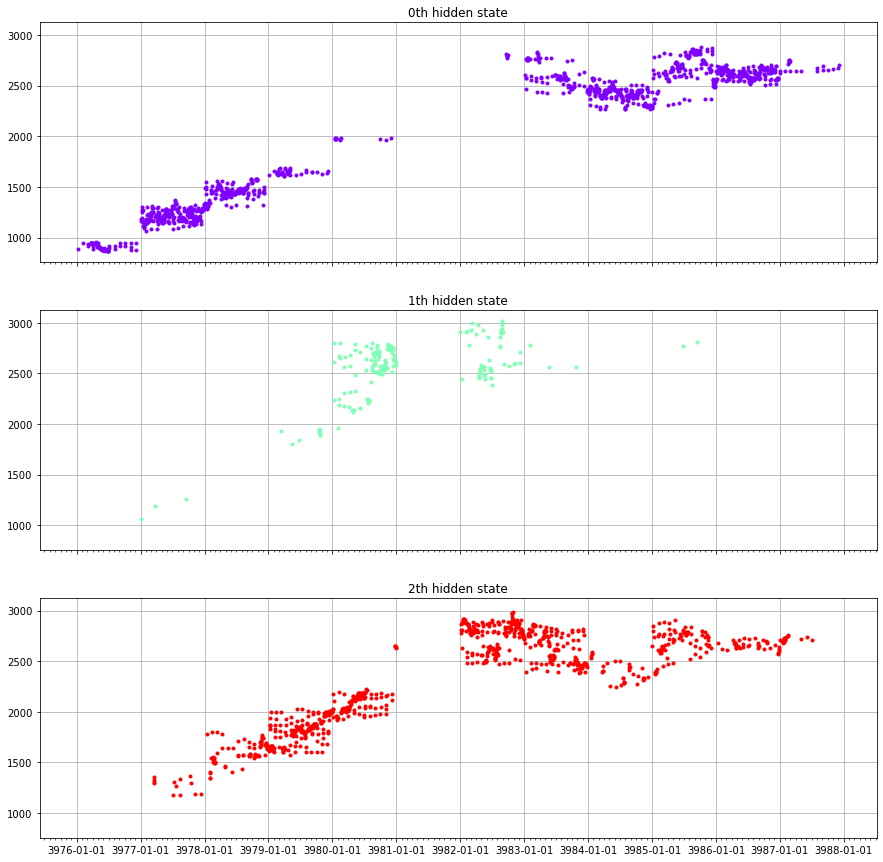

In [15]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

    Returns        Volume
0 -0.290987  3.130709e+07
1  3.332946  3.971963e+08
2  1.611570  9.056348e+07


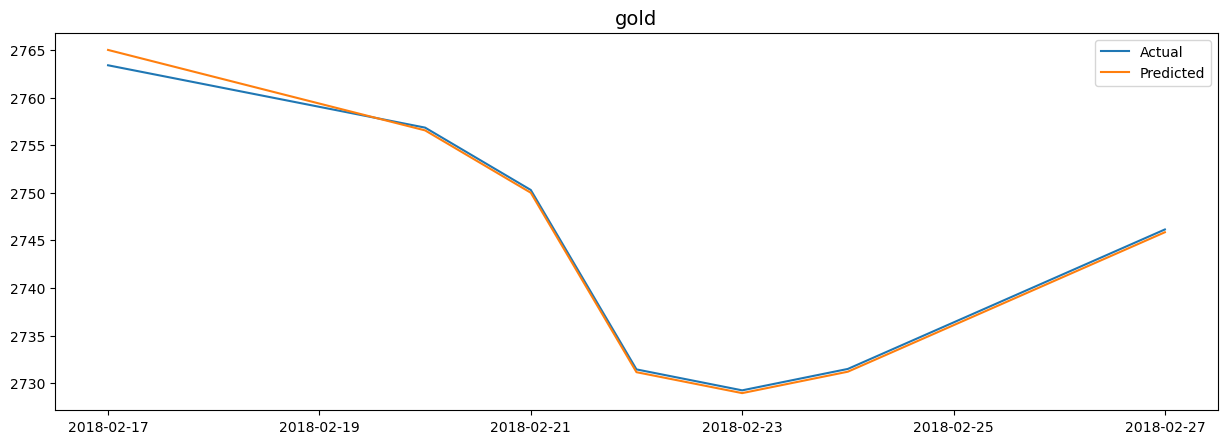

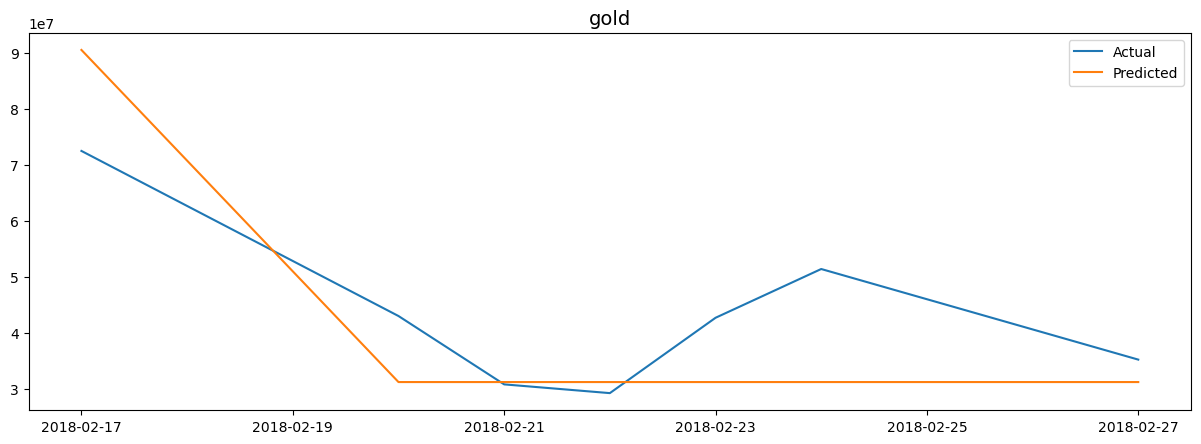

In [16]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in df], dtype=int)

predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = df[-lastN+idx][1]
    volume = df[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()
